In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections
import category_encoders as ce

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [87]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Загружаем данные

In [17]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [18]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [19]:
# Подгрузим наши данные из соревнования
DATA_DIR = 'sf-booking'
# DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [21]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [23]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [24]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [25]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [26]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], ignore_index=True) # объединяем

# Изучаем данные

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Данный датасет состоит  из 17 признаков(столбцов) + 1 добавили(sample).\
Данные следующих типов представлены: 4 признака - float, 6 - int, 8 - object.\
review_date представлены типом object, данный признак можно представить datetime.\
В признаках lat и lng есть пропуски

In [28]:
# Пропущенные данные
print(data.isnull().sum()[data.isnull().sum() > 0]) 

lat    3268
lng    3268
dtype: int64


In [29]:
# Дубликаты 
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 336


In [30]:
data[data.duplicated()].head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
21413,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,9/27/2015,8.9,Hotel Le Sainte Beuve,Costa Rica,No Negative,0,143,Ir s a lovely boutique hotel full of Parisian...,53,4,10.0,"[' Leisure trip ', ' Family with older childre...",676 day,48.843900,2.329486,1
53110,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,9/25/2016,9.0,H tel Baume,Lebanon,nothing at all,4,253,bed was great staff are wonderful location ve...,10,1,10.0,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",312 day,48.850152,2.339278,1
54461,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/2/2016,7.9,H tel Concorde Montparnasse,Israel,The room to far from elevator,7,2515,Staff very nice and helpful Breakfast was per...,17,2,8.3,"[' Couple ', ' Classic Twin Room ', ' Stayed 3...",366 day,48.838108,2.318669,1
56542,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,7/2/2017,9.0,H tel Baume,Romania,Breakfast was a huge joke It was the worst po...,19,253,Room was great nice and spacious appartment f...,14,7,7.9,"[' Leisure trip ', ' Family with young childre...",32 days,48.850152,2.339278,1
65789,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,8/11/2015,9.0,H tel Baume,United Kingdom,No Negative,0,253,Friendly reception staff clean bathroom and l...,11,1,10.0,"[' Leisure trip ', ' Couple ', ' Superior Doub...",723 day,48.850152,2.339278,1


При быстром просмотре на дублирующие данные, можно предположить что они таковыми не считаются.\
Для подверждение, выведим количество уникальных данных для каждого признака

In [31]:
data[data.duplicated()].nunique()

hotel_address                                  11
additional_number_of_scoring                   11
review_date                                   256
average_score                                   8
hotel_name                                     11
reviewer_nationality                           55
negative_review                               249
review_total_negative_word_counts              65
total_number_of_reviews                        11
positive_review                               299
review_total_positive_word_counts              57
total_number_of_reviews_reviewer_has_given     42
reviewer_score                                 21
tags                                          205
days_since_review                             256
lat                                            11
lng                                            11
sample                                          2
dtype: int64

# Очистка данных, создание новых признаков  

## 1.Hotel_address

In [32]:
print(data['hotel_address'][2] + '\n')
print(data['hotel_address'][10] + '\n')
print(data['hotel_address'][278] + '\n')
print(data['hotel_address'][1258] + '\n')
print(data['hotel_address'][515734])

151 bis Rue de Rennes 6th arr 75006 Paris France

Molenwerf 1 1014 AG Amsterdam Netherlands

Lakeside Way Brent London HA9 0BU United Kingdom

78 84 Sussex Gardens Westminster Borough London W2 1UH United Kingdom

Duc De Medinaceli 8 Ciutat Vella 08002 Barcelona Spain


Из признака 'hotel_address' можно извлечь информацию о стране и городе отеля. Извлекем город и страну и подчистим адрес от дублирующих данных(город и страна)  

In [33]:
# Функция извлечения города в котором находится отель
def city_hotels(address):
    ls_city = address.split()
    if ls_city[-1] == 'Kingdom':
        return ls_city[-5]
    return ls_city[-2]

In [34]:
# Функция извлечения страны в котором находится отель
def country_hotels(address):
    ls_city = address.split()
    if ls_city[-1] == 'Kingdom':
        return ' '.join(ls_city[-2:])
    return  ls_city[-1]

In [35]:
# Функция для очистки данных  от названия города и страну
def address_hotels(address):
    ls_city = address.split()
    if ls_city[-1] == 'Kingdom':
        return ' '.join(ls_city[:-5])
    return ' '.join(ls_city[:-2])

In [36]:
# преобразуем признак 'hotel_address' и создаем два новых 'country_hotel' и 'city_hotel'
data['city_hotel'] = data['hotel_address'].apply(city_hotels)
data['country_hotel'] = data['hotel_address'].apply(country_hotels)
data['hotel_address'] = data['hotel_address'].apply(address_hotels)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [37]:
print(data['city_hotel'].unique())
print(data['country_hotel'].unique())

['London' 'Paris' 'Amsterdam' 'Milan' 'Vienna' 'Barcelona']
['United Kingdom' 'France' 'Netherlands' 'Italy' 'Austria' 'Spain']


In [38]:
data['city_hotel'].value_counts()

city_hotel
London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: count, dtype: int64

Text(0.5, 1.0, 'Распределение количества рецензентов для отелей взависимости от города')

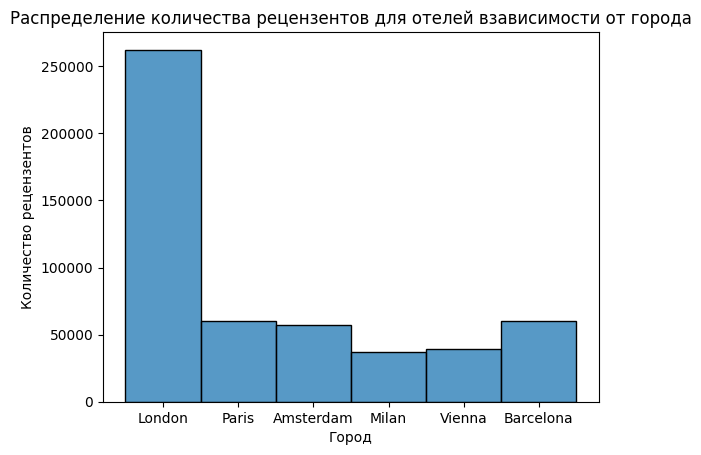

In [39]:
ax = sns.histplot(data['city_hotel'])
ax.set(xlabel='Город', ylabel='Количество рецензентов')
ax.set_title('Распределение количества рецензентов для отелей взависимости от города')

Самый популярный город - Лондон, т.к. больше всего оставили оценки для отелей Лондона.  

## 2. Review_date

In [40]:
# Преобразуем в тип datetime
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=True)

#Создадим новый признак квартал в котором была выставлена оценка и написан отзыв
data['review_quarter'] = data['review_date'].dt.to_period('Q')
data['review_quarter'][:5]

0    2016Q1
1    2017Q1
2    2016Q4
3    2015Q3
4    2016Q1
Name: review_quarter, dtype: period[Q-DEC]

In [41]:
# Выведим в признак review_quarter только номер квартал и преобразуем в тип int
data['review_quarter'] = data['review_quarter'].apply(lambda x: int(str(x)[-1]))

In [42]:
data['review_quarter'].value_counts()

review_quarter
3    142418
2    132269
1    121631
4    119420
Name: count, dtype: int64

Больше отзывов приходиться на 2 и 3 кварталы, это апрель - сентябрь. На эти месяцы приходиться сезон отпусков.

In [43]:
#удалим столбец review_date
data.drop('review_date', axis=1, inplace=True)

## 3. lat и lnf. Заполняем пропуски

In [44]:
# В пропущенных значений широты и  долготы,  заполняем средним значением 
# координат отелей, находящиеся в этом же городе
for city in data['city_hotel'].value_counts().index:
    mask = data['city_hotel'] == city
    if data[mask].isnull().sum()['lat'] > 0 and data[mask].isnull().sum()['lng'] > 0:
        value = {'lat': data[mask]['lat'].mean(), 'lng': data[mask]['lng'].mean()}
        data[mask] = data[mask].fillna(value)

In [45]:
print(data.isnull().sum()[data.isnull().sum() > 0])

Series([], dtype: int64)


## 4. Negative_review и positive_review

In [46]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johno\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
data['negative_review'][4511]

'No Negative'

In [48]:
sent_analyzer.polarity_scores(data['negative_review'][4511])

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

In [49]:
data['positive_review'][4511]

' Great place to stay in Paris the kind of Hotel we all want but find difficult to locate '

In [50]:
sent_analyzer.polarity_scores(data['positive_review'][4511])

{'neg': 0.148, 'neu': 0.683, 'pos': 0.169, 'compound': -0.1406}

In [51]:
data['negativ_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
data['negativ_neu'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
data['negativ_pos'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
data['negativ_compound'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

In [52]:
data['positive_neg'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
data['positive_neu'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
data['positive_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
data['positive_compound'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

## 5. Days_since_review

In [53]:
data['days_since_review'][:5]

0    531 day
1    203 day
2    289 day
3    681 day
4    516 day
Name: days_since_review, dtype: object

In [54]:
# Преобразуем данный признак в тип int.
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]) )

## 6. Reviewer_nationality

In [55]:
data['reviewer_nationality'][0]

' United Kingdom '

In [56]:
data['reviewer_nationality'][20]

' United Kingdom '

В признаке "reviewer_nationality" в данных есть пробел  в начале и конце  строки. Уберем его.
Сделаем принак, который показывает являестся ли reviewer гражданином страны, где он оставлял  отзыв отеля

In [57]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: ' '.join(x.split()))
data['citizenship'] = np.where(data['country_hotel'] == data['reviewer_nationality'], 1, 0)

## 7. Tag 

In [58]:
data['tags'][0]

"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

In [59]:
data['tags'][358]

"[' Leisure trip ', ' Couple ', ' Double Guest Room ', ' Stayed 1 night ']"

In [60]:
def transformation_tag(tag):
    ls = tag.split(" ', ' ")
    ls[0] = ls[0][3:]
    ls[-1] = ls[-1][:-3]
    return ls

data['tags'] = data['tags'].apply(transformation_tag)

In [61]:
data['tags'][0]

['Leisure trip',
 'Couple',
 'Studio Suite',
 'Stayed 2 nights',
 'Submitted from a mobile device']

In [62]:
data['tags'][0][0]

'Leisure trip'

Данные представлены ввиде списка

In [63]:
# Выведим самые популярные теги (50)
c = collections.Counter()
for tags in data['tags']:
    for tag in tags:
        c[tag] += 1

c.most_common()[0:50:]

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12393),
 ('Stayed 6 nights', 9776),
 ('Standard Twin Room', 9745),
 ('Single Room', 9670),
 ('Twin Room', 8321),
 ('Stayed 7 nights', 7399),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6107),
 ('Superior Twin Room', 6064),
 ('Deluxe Double or Twin Room', 5998),
 ('Club Double Room', 5908),
 ('Qu

По часто встречающимся можно создать новые признаки

In [64]:
# количество ночей проведенных в отеле
def numerical(string):
    for elem in string.split():
        if elem.isdigit():
            return int(elem)
    return False

def total_night(tags):
    for tag in  tags:
        if 'night' in tag and numerical(tag) != False:
            return numerical(tag)
    return 0

data['total_nights'] = data['tags'].apply(total_night)

In [65]:
data['total_nights'].value_counts()

total_nights
1     193644
2     133936
3      95825
4      47817
5      20843
6       9776
7       7399
8       2502
9       1293
10       889
11       418
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
30        11
27        11
22        10
23        10
28         7
26         7
25         7
24         6
29         5
31         1
Name: count, dtype: int64

Определим является ли у reviewer туристическая поездка или бизнес поездка

In [66]:
def leisure_trip(tags):
    for tag in tags:
        if ('Leisure trip' in tag) or ('travel' in tag):
            return 1
    return 0 

def business_trip(tags):
    for tag in tags:
        if ('Business trip' in tag):
            return 1
    return 0


In [67]:
data['leisure_trip'] = data['tags'].apply(leisure_trip)
data['business_trip'] = data['tags'].apply(business_trip)

Определим признаки в отели номер снимали пара или семья с детьми или групповая поездка

In [68]:
def couple(tags):
    for tag in tags:
        if ('Couple' in tag):
            return 1
    return 0


def children(tags):
    for tag in tags:
        if ('children' in tag):
            return 1
    return 0

def group(tags):
    for tag in tags:
        if ('Group' in tag):
            return 1
    return 0

In [69]:
data['couple'] = data['tags'].apply(couple)
data['children'] = data['tags'].apply(children)
data['group'] = data['tags'].apply(group)

Выведим признак c какого устройства отправлен тэг

In [70]:
def submitted_mobile(tags): 
    for tag in tags:
        if 'Submitted from a mobile device' in tag:
            return 1
    return 0


In [71]:
data['submitted_mobile'] = data['tags'].apply(submitted_mobile)

Отдельно выделим признаки описывающие роскошные номера

In [72]:
def luxe(tags):
    for tag in tags:
        if 'Deluxe' in tag:
            return 1
        elif 'Luxury' in tag:
            return 1
    return 0

In [73]:
data['luxe'] = data['tags'].apply(luxe)

## 8. Hotel_name

Отели представленные в данных могут пренадлежать международным брендам гостинечного бизнеса
Возьмем ТОП-10 гостиничных брендов в стоимостном выражении: 
* Hilton
* Marriott
* Hyatt
* Sheraton
* Holiday
* Courtyard
* Hampton
* Mercure
* Ramada
* SHANGRI-LA ASIA

Определим новый признак пренадлежности отеля к определенному бренду

In [74]:
brand = ['hilton', 'marriott', 'hyatt', 'sheraton', 'holiday', 'courtyard', 'hampton', 'mercure', 'ramada', 'shangri-la']

In [75]:
def brand(name_hotels):
    brand = ['hilton', 'marriott', 'hyatt', 'sheraton', 'holiday', 'courtyard', 'hampton', 'mercure', 'ramada', 'shangri-la']
    for elem in name_hotels.split():
        if elem.lower() in brand:
            return elem
    return 'other'

In [76]:
# создадим новый признак hotel_brand
data['brand'] = data['hotel_name'].apply(brand)

In [77]:
data['brand'].value_counts()

brand
other        443317
Hilton        35128
Holiday       15874
Mercure       10424
Marriott       5684
Ramada         2050
Hyatt          1933
Courtyard       632
Hampton         362
Sheraton        334
Name: count, dtype: int64

# Преобразование признаков

Выполним кодирование номинального категориального признака city_hotel методом OneHot Encoding

In [78]:
encoder = ce.OneHotEncoder(cols=['city_hotel', 'brand']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data[['city_hotel','brand']])
data = pd.concat([data, type_bin], axis=1)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 54 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [81]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

<Axes: >

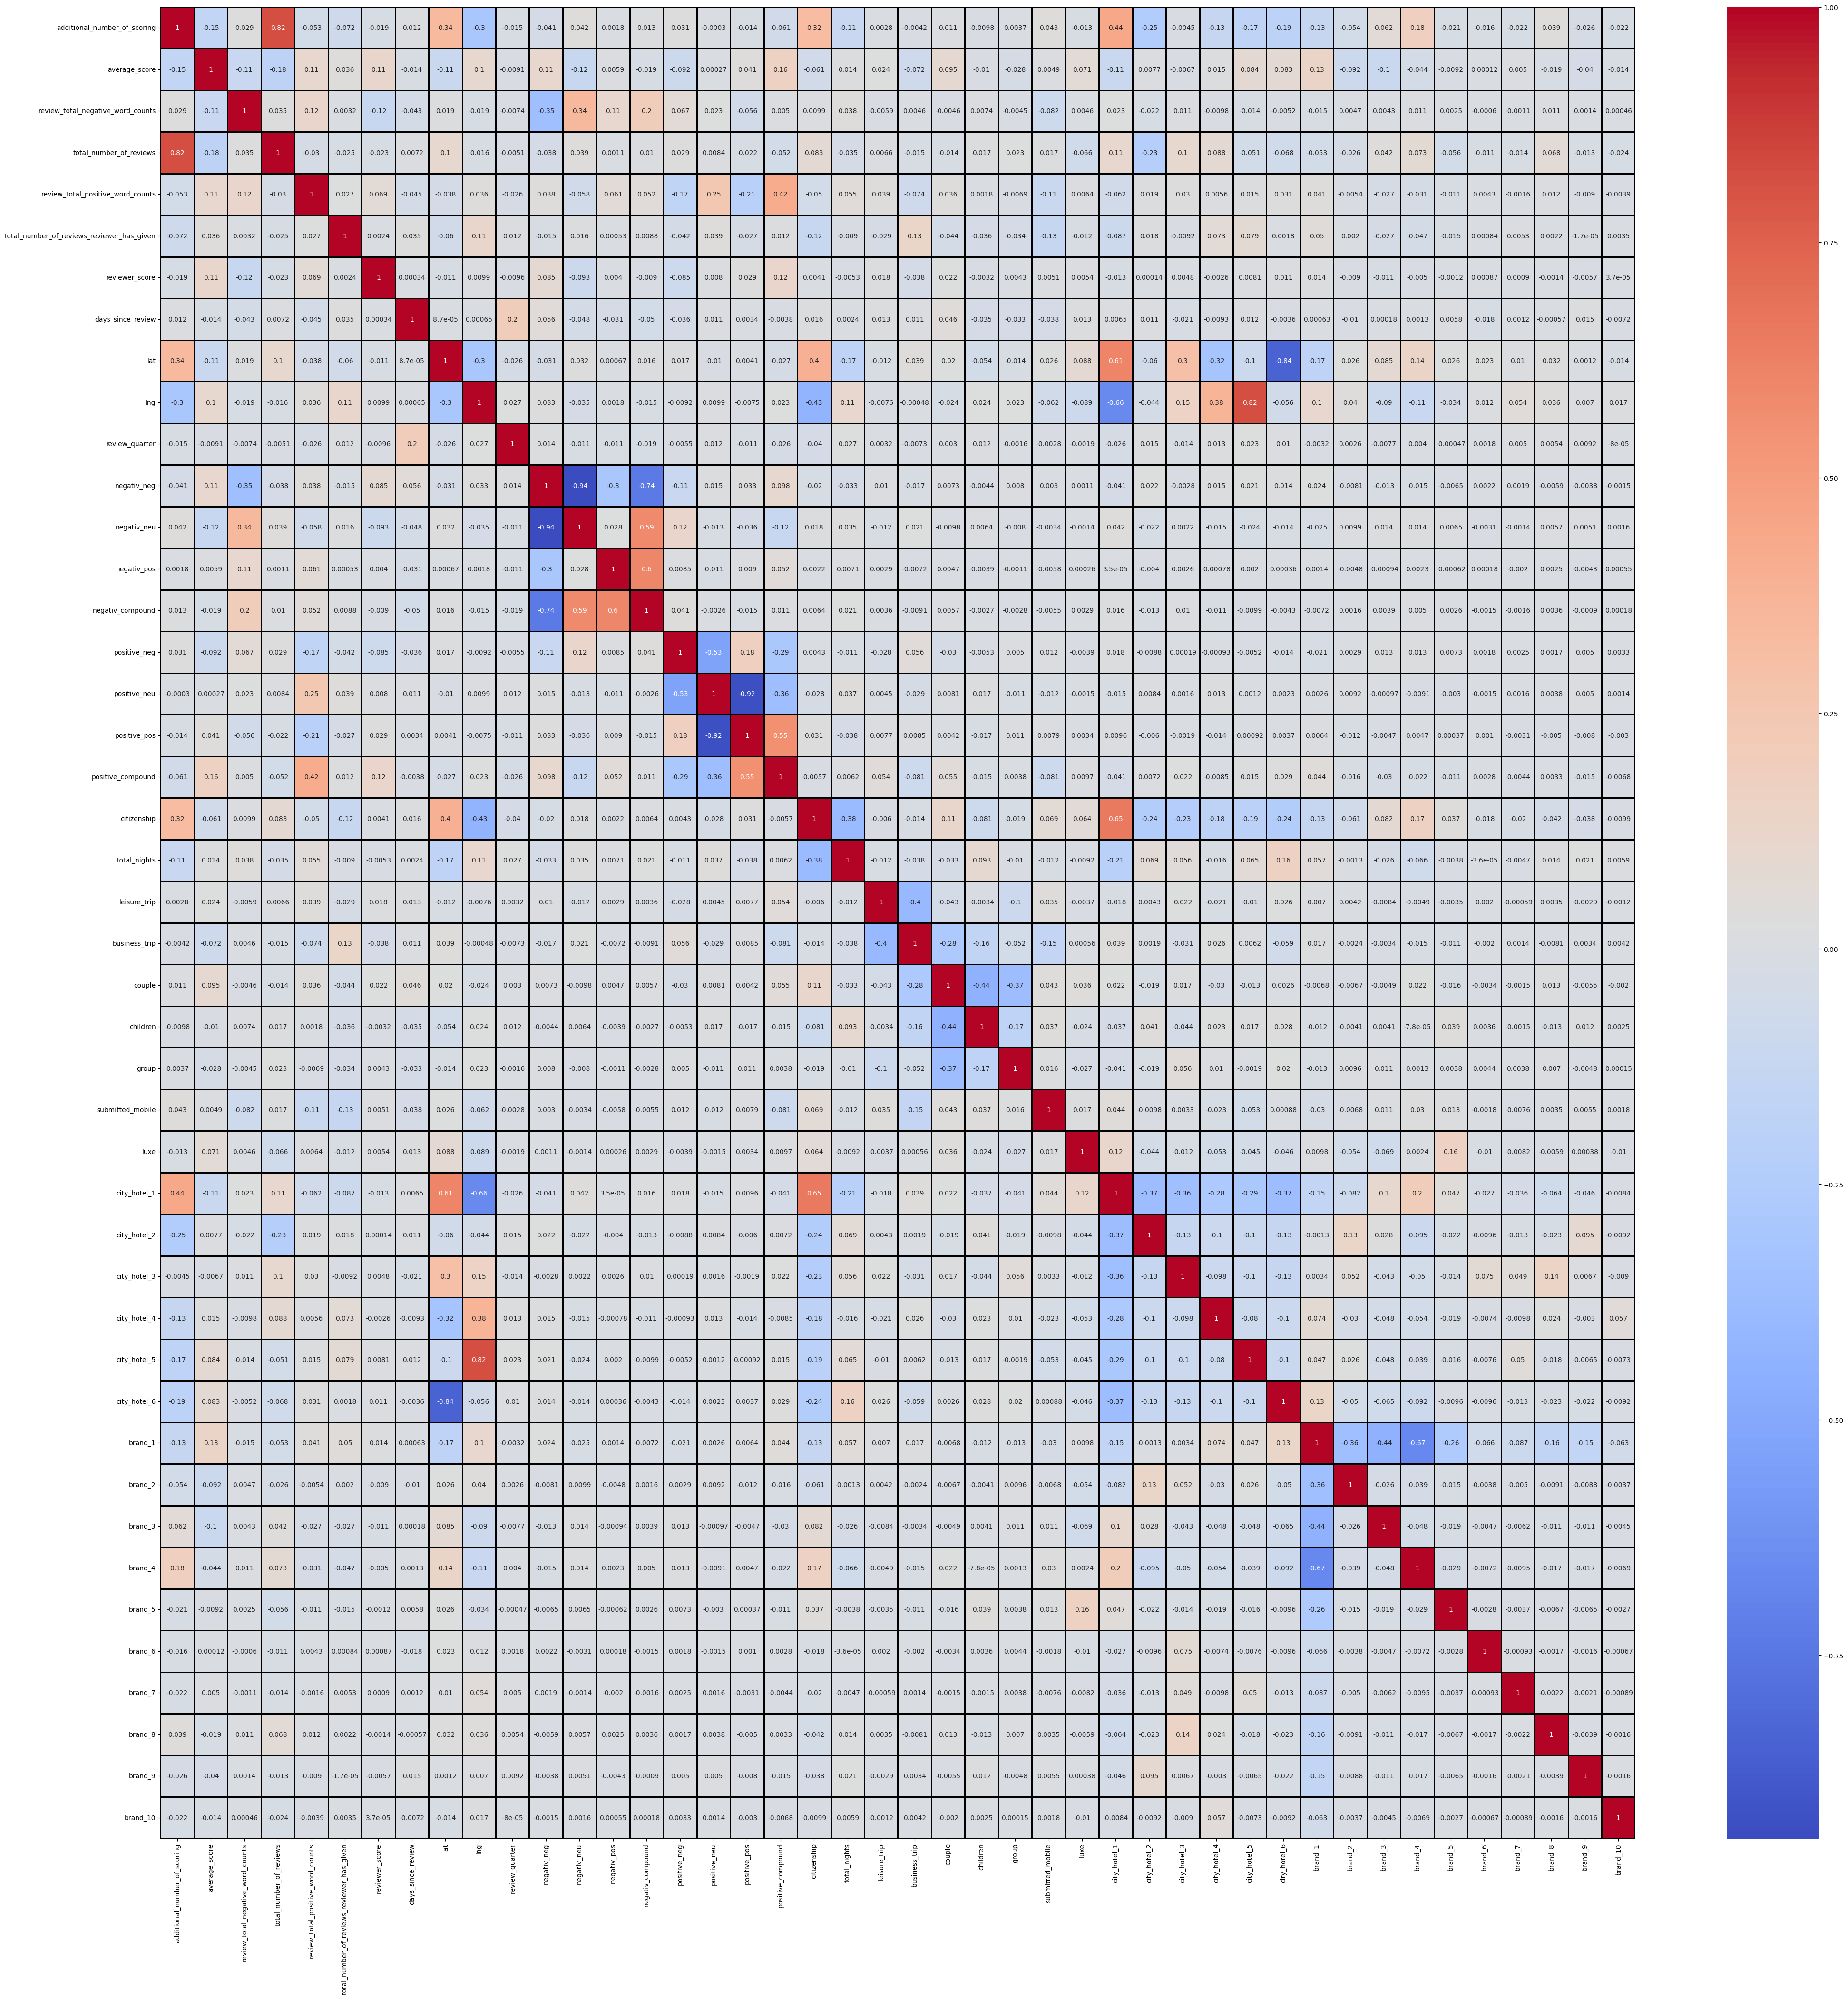

In [82]:
plt.rcParams['figure.figsize'] = (50,50)
sns.heatmap(data.drop(['sample'], axis=1).corr(), fmt='.2g', annot=True, cmap= 'coolwarm', 
            linewidths=2, linecolor='black')

# Обучение модели

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   days_since_review                           515738 non-null  int64  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

In [84]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [85]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [86]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 44), (386803, 44), (386803, 43), (309442, 43), (77361, 43))

In [88]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [89]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


In [90]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8788546548002221


<Axes: >

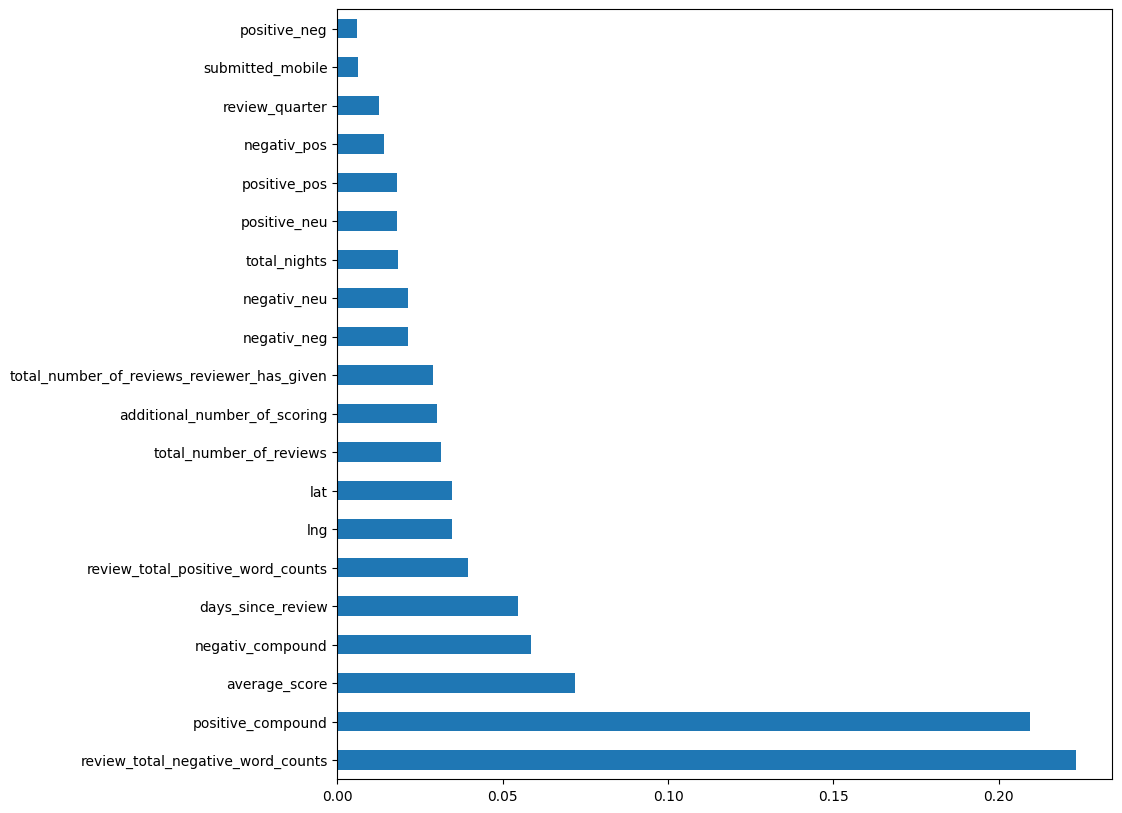

In [91]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [92]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10
464190,757,8.7,0,5236,9,1,0.0,529,52.357655,4.844576,...,1,0,0,0,0,0,0,0,0,0
437926,834,9.1,0,4687,29,3,0.0,660,52.370545,4.888644,...,1,0,0,0,0,0,0,0,0,0
396934,253,8.4,6,2586,0,1,0.0,57,52.358881,4.988604,...,1,0,0,0,0,0,0,0,0,0
395049,196,9.3,27,931,37,1,0.0,387,51.520181,-0.125696,...,1,0,0,0,0,0,0,0,0,0
402303,1485,7.5,70,6977,11,1,0.0,373,51.519569,-0.170521,...,0,0,0,1,0,0,0,0,0,0
448635,570,9.3,6,2319,18,14,0.0,616,51.505696,-0.101525,...,0,0,0,1,0,0,0,0,0,0
474185,22,8.1,2,241,10,2,0.0,43,48.865199,2.304508,...,1,0,0,0,0,0,0,0,0,0
399037,420,8.6,19,4379,15,33,0.0,205,41.379896,2.141243,...,1,0,0,0,0,0,0,0,0,0
466245,2682,7.1,13,9086,0,1,0.0,396,51.501910,-0.023221,...,1,0,0,0,0,0,0,0,0,0
471901,74,8.7,10,873,0,1,0.0,471,41.389524,2.149031,...,1,0,0,0,0,0,0,0,0,0


In [93]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [94]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [95]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.7s finished


In [96]:
predict_submission

array([8.665, 7.112, 8.427, ..., 8.432, 9.678, 7.133])

In [97]:
list(sample_submission)

['reviewer_score', 'id']

In [98]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.665,488440
1,7.112,274649
2,8.427,374688
3,9.755,404352
4,9.639,451596
5,9.056,302161
6,7.695,317079
7,7.397,13963
8,8.456,159785
9,7.346,195089
